 Evaluating all queries:   0%|          | 0/50 [00:00<?, ?it/s]


 Query ID: 1
 Query: teacher get tenure user heard country give teacher tenure others dont interested reason tenure user search positive negative argument situation school teacher university professor interest highly relevant argument make clear statement tenure teacher school university relevant argument consider tenure generally specifically teacher instead talk tenure consider situation teacher financial independence
 Relevant docs: 23
   Precision@1000: 0.0020
   Recall@1000: 0.0870
   AP: 0.8333
   NDCG@1000: 1.0000
   Top 5 Retrieved: ['Sc065954f-A24a16870', 'S51530f3f-A6ac2dcba', 'S24e47090-A5a7440e2', 'S1e496b65-A76ec518a', 'S2f6dfebd-A95a07508']
   Relevant Retrieved: ['Sc065954f-A24a16870', 'S24e47090-A5a7440e2']

 Query ID: 2
 Query: vaping ecigarettes safe consider switch smoking vaping user wonder extent vaping safer new risk may involve compare smoking risk clear vaping market benefit raise doubt highly relevant argument support deny safety vaping give valid reason relev

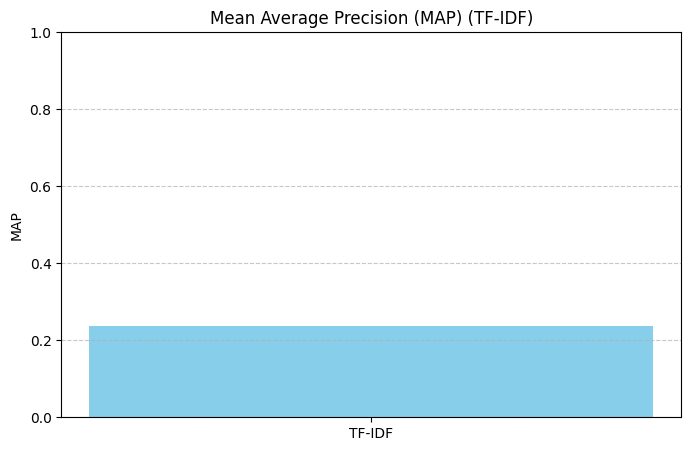

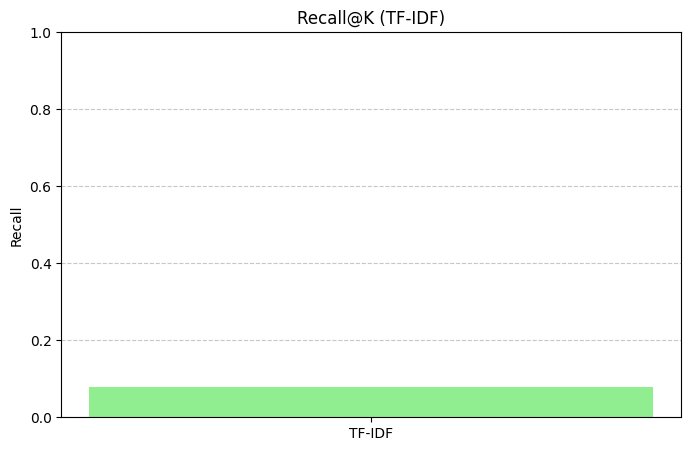

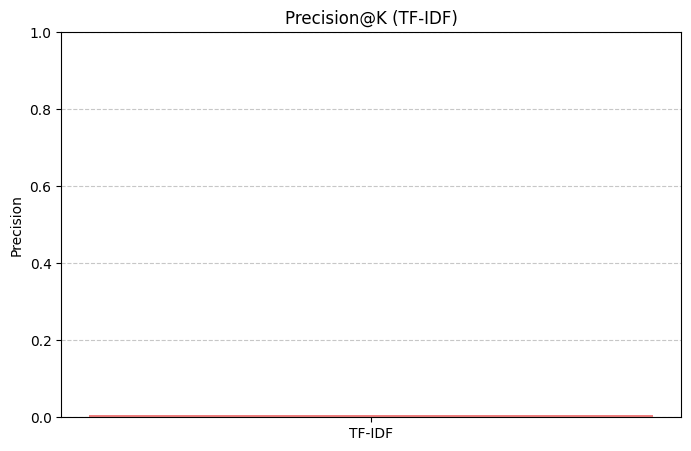

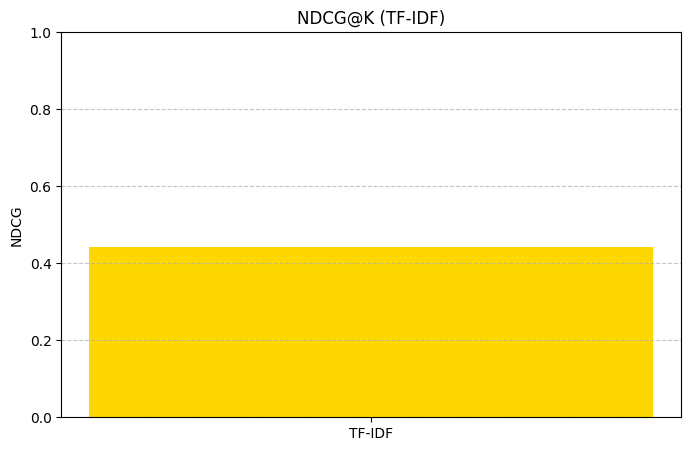


 All queries evaluated successfully!


In [3]:
import requests
import csv
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score, ndcg_score
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 📡 API Settings
# ----------------------------
TFIDF_URL = "http://localhost:8003/search"  # URL لخدمة الـ TF-IDF
DATASET = "argsme"
TOP_K = 1000

# ----------------------------
#  تحميل الكويريز
# ----------------------------
def load_queries(path, num_queries=None):
    queries = []
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            queries.append({"query_id": row["query_id"], "query": row["processed_text"]})
            if num_queries and len(queries) >= num_queries:
                break
    return queries

#  تحميل qrels
def load_qrels(path):
    qrels = defaultdict(dict)
    with open(path, encoding="utf-8") as f:
        next(f)
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) < 3:
                continue
            qid, docid, rel = parts[:3]
            qrels[qid][docid] = int(rel)
    return qrels

# ----------------------------
#  إرسال الكويري إلى خدمة الـ TF-IDF
# ----------------------------
def search_tfidf(query, dataset=DATASET, top_k=TOP_K):
    payload = {
        "dataset": dataset,
        "query": query,
        "top_k": top_k,
        "method": "tfidf"
    }
    response = requests.post(TFIDF_URL, json=payload)
    response.raise_for_status()
    results = response.json()["results"]
    return results

# ----------------------------
#  حساب المقاييس
# ----------------------------
def compute_metrics(gt, pred_docs, pred_scores, top_k):
    hits = np.array([1 if doc in gt else 0 for doc in pred_docs])
    true_rels = np.array([gt.get(doc, 0) for doc in pred_docs])
    ap = average_precision_score(hits, pred_scores) if hits.sum() > 0 else 0.0
    precision = hits.sum() / top_k
    recall = hits.sum() / len(gt) if len(gt) > 0 else 0.0
    ndcg = ndcg_score([true_rels], [pred_scores]) if true_rels.sum() > 0 else 0.0
    return ap, precision, recall, ndcg

# ----------------------------
# 🏁 بدء التقييم
# ----------------------------
queries_path = r"D:\5th year\IR\Final_project_IR\data\vectors\argsme\processed\ARGSME_cleaned_queries.tsv"
qrels_path = r"D:\5th year\IR\Final_project_IR\data\vectors\argsme\qrels.tsv"

queries = load_queries(queries_path)  # تحميل جميع الكويريز
qrels = load_qrels(qrels_path)

metrics = {"AP": [], "Recall": [], "Precision": [], "NDCG": []}
failed_queries = []

for q in tqdm(queries, desc=" Evaluating all queries"):
    qid = q["query_id"]
    query_text = q["query"]
    gt = qrels.get(qid, {})

    print(f"\n Query ID: {qid}")
    print(f" Query: {query_text}")
    print(f" Relevant docs: {len(gt)}")

    try:
        results = search_tfidf(query_text)
        pred_docs = [str(r["doc_id"]) for r in results[:TOP_K]]
        pred_scores = [r["score"] for r in results[:TOP_K]]
        ap, precision, recall, ndcg = compute_metrics(gt, pred_docs, pred_scores, TOP_K)

        metrics["AP"].append(ap)
        metrics["Recall"].append(recall)
        metrics["Precision"].append(precision)
        metrics["NDCG"].append(ndcg)

        print(f"   Precision@{TOP_K}: {precision:.4f}")
        print(f"   Recall@{TOP_K}: {recall:.4f}")
        print(f"   AP: {ap:.4f}")
        print(f"   NDCG@{TOP_K}: {ndcg:.4f}")
        print(f"   Top 5 Retrieved: {pred_docs[:5]}")
        print(f"   Relevant Retrieved: {[doc for doc in pred_docs[:5] if doc in gt]}")

    except Exception as e:
        print(f" Error in query_id={qid}: {e}")
        metrics["AP"].append(0)
        metrics["Recall"].append(0)
        metrics["Precision"].append(0)
        metrics["NDCG"].append(0)
        failed_queries.append(qid)

# ----------------------------
#  رسم التشارتات
# ----------------------------
def plot_metric(metric_values, metric_name, ylabel, color):
    plt.figure(figsize=(8, 5))
    plt.bar(["TF-IDF"], [metric_values], color=color)
    plt.title(f"{metric_name} (TF-IDF)")
    plt.ylabel(ylabel)
    plt.ylim(0, 1)  # المقاييس بين 0 و 1
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# حساب المتوسط
avg_ap = np.mean(metrics["AP"])
avg_recall = np.mean(metrics["Recall"])
avg_precision = np.mean(metrics["Precision"])
avg_ndcg = np.mean(metrics["NDCG"])

print("\n === FINAL AVERAGE RESULTS ===")
print(f"MAP: {avg_ap:.4f}")
print(f"Recall@k: {avg_recall:.4f}")
print(f"Precision@k: {avg_precision:.4f}")
print(f"NDCG@k: {avg_ndcg:.4f}")

# رسم كل مقياس
plot_metric(avg_ap, "Mean Average Precision (MAP)", "MAP", "skyblue")
plot_metric(avg_recall, "Recall@K", "Recall", "lightgreen")
plot_metric(avg_precision, "Precision@K", "Precision", "lightcoral")
plot_metric(avg_ndcg, "NDCG@K", "NDCG", "gold")

if failed_queries:
    print(f"\n Failed queries: {failed_queries}")
else:
    print("\n All queries evaluated successfully!")


Evaluating all queries:   0%|          | 0/1444 [00:00<?, ?it/s]


Query ID: 123839
Query: yanni
Relevant docs: 6
   Precision@1000: 0.0060
   Recall@1000: 1.0000
   AP: 0.9484
   NDCG@1000: 0.9018
   Top 5 Retrieved: ['806300', '123839', '806075', '836567', '806326']
   Relevant Retrieved: ['806300', '123839', '806075', '836567']

Query ID: 188629
Query: k pop
Relevant docs: 6
   Precision@1000: 0.0060
   Recall@1000: 1.0000
   AP: 0.2002
   NDCG@1000: 0.6423
   Top 5 Retrieved: ['188629', '2276840', '2142092', '1557927', '2191096']
   Relevant Retrieved: ['188629']

Query ID: 13898
Query: venice film festival
Relevant docs: 6
   Precision@1000: 0.0030
   Recall@1000: 0.5000
   AP: 0.3441
   NDCG@1000: 0.7266
   Top 5 Retrieved: ['13898', '1027679', '1703661', '2354140', '1973423']
   Relevant Retrieved: ['13898']

Query ID: 316959
Query: downtown brooklyn
Relevant docs: 9
   Precision@1000: 0.0050
   Recall@1000: 0.5556
   AP: 0.2382
   NDCG@1000: 0.6720
   Top 5 Retrieved: ['316959', '1465433', '2156815', '1836641', '395421']
   Relevant Retrieved

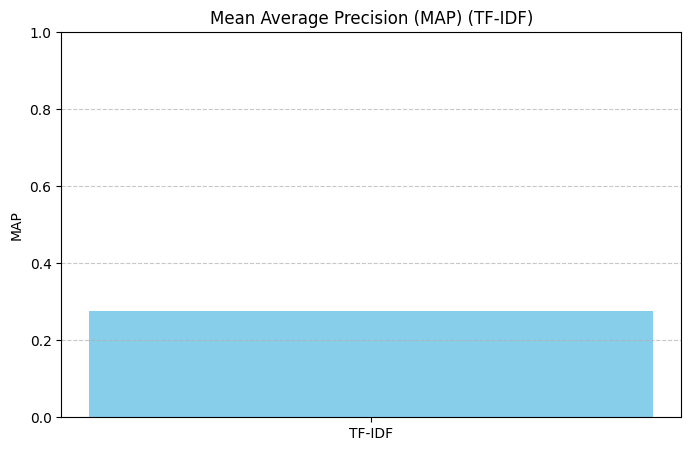

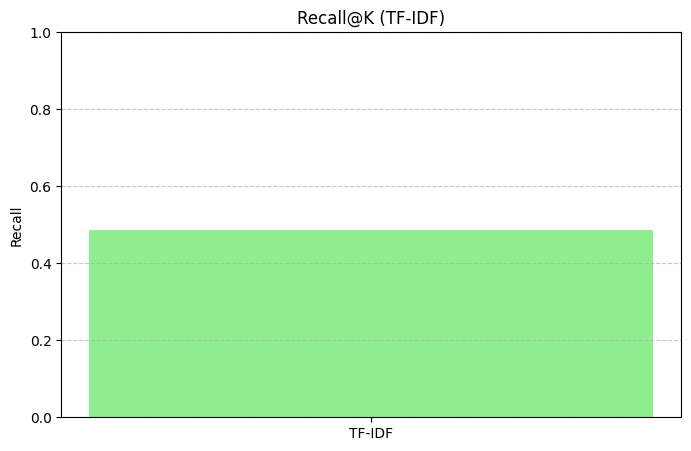

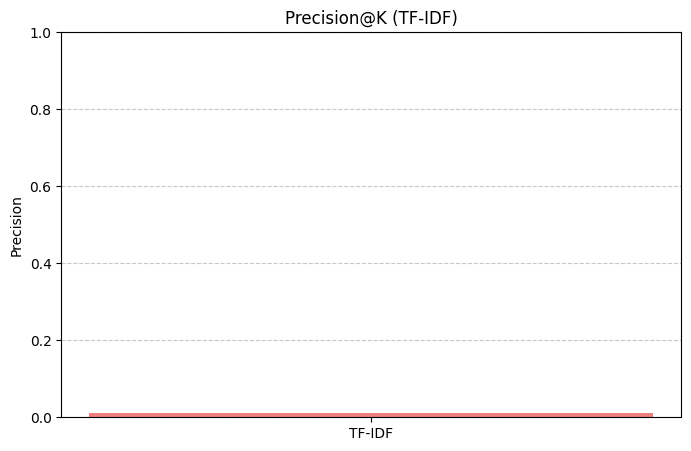

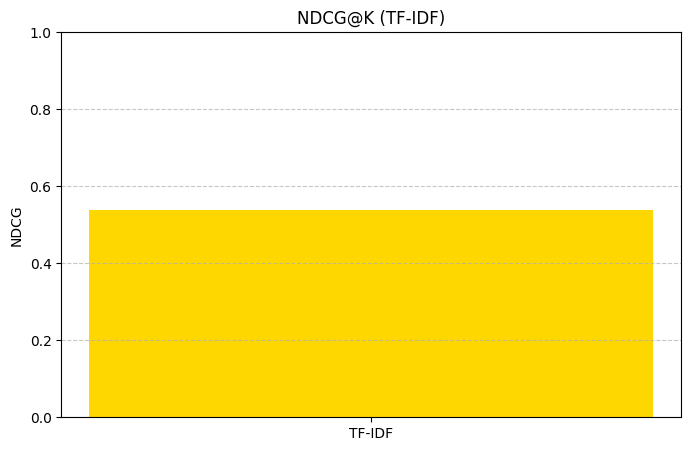


Failed queries: ['112935']


In [5]:
import requests
import csv
from collections import defaultdict
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score, ndcg_score
import numpy as np
import matplotlib.pyplot as plt

TFIDF_URL = "http://localhost:8003/search"
DATASET = "wikir"
TOP_K = 1000

def load_queries(path, num_queries=None):
    queries = []
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            queries.append({"query_id": row["query_id"], "query": row["text"]})
            if num_queries and len(queries) >= num_queries:
                break
    return queries

def load_qrels(path):
    qrels = defaultdict(dict)
    with open(path, encoding="utf-8") as f:
        reader = csv.DictReader(f, delimiter="\t")
        for row in reader:
            qid = row["query_id"]
            docid = row["doc_id"]
            rel = int(row["relevance"])
            qrels[qid][docid] = rel
    return qrels

def search_tfidf(query, dataset=DATASET, top_k=TOP_K):
    payload = {
        "dataset": dataset,
        "query": query,
        "top_k": top_k,
        "method": "tfidf"
    }
    response = requests.post(TFIDF_URL, json=payload)
    response.raise_for_status()
    results = response.json()["results"]
    return results

def compute_metrics(gt, pred_docs, pred_scores, top_k):
    hits = np.array([1 if doc in gt else 0 for doc in pred_docs])
    true_rels = np.array([gt.get(doc, 0) for doc in pred_docs])
    ap = average_precision_score(hits, pred_scores) if hits.sum() > 0 else 0.0
    precision = hits.sum() / top_k
    recall = hits.sum() / len(gt) if len(gt) > 0 else 0.0
    ndcg = ndcg_score([true_rels], [pred_scores]) if true_rels.sum() > 0 else 0.0
    return ap, precision, recall, ndcg

queries_path = r"D:\5th year\IR\Final_project_IR\data\vectors\wikir\processed\queries_cleaned.tsv"
qrels_path = r"D:\5th year\IR\Final_project_IR\data\vectors\wikir\qrels.tsv"

queries = load_queries(queries_path)
qrels = load_qrels(qrels_path)

metrics = {"AP": [], "Recall": [], "Precision": [], "NDCG": []}
failed_queries = []

for q in tqdm(queries, desc="Evaluating all queries"):
    qid = q["query_id"]
    query_text = q["query"]
    gt = qrels.get(qid, {})

    print(f"\nQuery ID: {qid}")
    print(f"Query: {query_text}")
    print(f"Relevant docs: {len(gt)}")

    try:
        results = search_tfidf(query_text)
        pred_docs = [str(r["doc_id"]) for r in results[:TOP_K]]
        pred_scores = [r["score"] for r in results[:TOP_K]]
        ap, precision, recall, ndcg = compute_metrics(gt, pred_docs, pred_scores, TOP_K)

        metrics["AP"].append(ap)
        metrics["Recall"].append(recall)
        metrics["Precision"].append(precision)
        metrics["NDCG"].append(ndcg)

        print(f"   Precision@{TOP_K}: {precision:.4f}")
        print(f"   Recall@{TOP_K}: {recall:.4f}")
        print(f"   AP: {ap:.4f}")
        print(f"   NDCG@{TOP_K}: {ndcg:.4f}")
        print(f"   Top 5 Retrieved: {pred_docs[:5]}")
        print(f"   Relevant Retrieved: {[doc for doc in pred_docs[:5] if doc in gt]}")

    except Exception as e:
        print(f"Error in query_id={qid}: {e}")
        metrics["AP"].append(0)
        metrics["Recall"].append(0)
        metrics["Precision"].append(0)
        metrics["NDCG"].append(0)
        failed_queries.append(qid)

def plot_metric(metric_values, metric_name, ylabel, color):
    plt.figure(figsize=(8, 5))
    plt.bar(["TF-IDF"], [metric_values], color=color)
    plt.title(f"{metric_name} (TF-IDF)")
    plt.ylabel(ylabel)
    plt.ylim(0, 1)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

avg_ap = np.mean(metrics["AP"])
avg_recall = np.mean(metrics["Recall"])
avg_precision = np.mean(metrics["Precision"])
avg_ndcg = np.mean(metrics["NDCG"])

print("\n=== FINAL AVERAGE RESULTS ===")
print(f"MAP: {avg_ap:.4f}")
print(f"Recall@k: {avg_recall:.4f}")
print(f"Precision@k: {avg_precision:.4f}")
print(f"NDCG@k: {avg_ndcg:.4f}")

plot_metric(avg_ap, "Mean Average Precision (MAP)", "MAP", "skyblue")
plot_metric(avg_recall, "Recall@K", "Recall", "lightgreen")
plot_metric(avg_precision, "Precision@K", "Precision", "lightcoral")
plot_metric(avg_ndcg, "NDCG@K", "NDCG", "gold")

if failed_queries:
    print(f"\nFailed queries: {failed_queries}")
else:
    print("\nAll queries evaluated successfully!")